In [4]:
import pandas as pd
import numpy as np
import sqlalchemy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


from data import db
from ml_model.analytics import exponential_decay, return_attribution

from ml_model.pipeline import get_pipeline, save_pipeline

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2



SYMBOL = "BTC"
start = "2019"
end = "2024"

DB = db.connect_db("database", interval="1h")
data = DB.get_data(SYMBOL)
data = data.loc[start:end]


def var_to_str(data):
    data.columns = [str(col) if isinstance(col, sqlalchemy.sql.elements.quoted_name) else col for col in data.columns]

var_to_str(data)

data.head()

,open,high,low,close,volume
time,,,,,
2019-01-01 00:00:00,3701.23,3713.00,3689.88,3700.31,686.367420
2019-01-01 01:00:00,3700.20,3702.73,3684.22,3689.69,613.539115
2019-01-01 02:00:00,3689.67,3695.95,3675.04,3690.00,895.302181
2019-01-01 03:00:00,3690.00,3699.77,3685.78,3693.13,796.714818
2019-01-01 04:00:00,3692.32,3720.00,3685.94,3692.71,1317.452909


### Triple Barrier

In [5]:
from ml_model.labels import compute_daily_volatility, get_events, get_bins, apply_pt_sl_on_t1


"""
# Définir les événements - par exemple, chaque jour à 00:00
events = pd.DataFrame(index=data.index)
#events = pd.DataFrame(index=data.resample('1D').first().dropna().index)
events['t1'] = events.index + pd.Timedelta(days=1)  # Barrière verticale après 1 jour
events['trgt'] = data['volatility'].resample('1D').last() * 2  # Objectif basé sur la volatilité
events['side'] = 1  # Par exemple, prendre des positions longues
"""

# Calcul de la volatilité
data['volatility'] = compute_daily_volatility(data['close'])

# Définir les événements - par exemple, chaque jour à 00:00
events = pd.DataFrame(index=data.index)
events['t1'] = pd.to_datetime(events.index.strftime('%Y-%m-%d')) +  pd.Timedelta(days=1)
events['trgt'] = data['volatility'] * 2 
events['side'] = 1 

# Appliquer la méthode des trois barrières
ptSl = [1, 1]
min_ret = 0.01
num_threads = 1

events = get_events(data['close'], events.index, ptSl, events['trgt'], min_ret, num_threads, t1=events['t1'])


molecule = events.index  # Liste des indices des événements
events2 = apply_pt_sl_on_t1(data['close'], events, ptSl, molecule)


labels = get_bins(events2, close=data['close'])
labels['out'] = np.where(labels['out'] == 0, 
                        np.where(labels['ret'] > 0, 1, -1),
                        labels['out']
                        )

labels['out'].value_counts()

out
 1.0    21918
-1.0    21846
Name: count, dtype: int64

In [6]:
from sklearn.ensemble import RandomForestClassifier
from ml_model.evaluation import evaluate_model
from ml_model.model import train_model
from ml_model.split import PurgedKFold
import joblib


data['Y'] = labels['out'].shift(1)


N = data.shape[0]
validation = int(0.8 * N)
validation_data = data.iloc[validation:]
data = data.iloc[:validation]


X = data.drop(columns=['Y'])
y = data['Y']

# model
model = RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10, random_state=42)

In [7]:
# Instancier le PurgedKFold
n_splits = 5
embargo = 300  # Définir selon la taille de votre ensemble de données
cv = PurgedKFold(n_splits=n_splits, embargo=embargo)


pipeline = get_pipeline()
#save_pipeline(pipeline)

for train_indices, test_indices in cv.split(X):
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    X_train_x, X_test_x = pipeline.fit_transform(X_train), pipeline.fit_transform(X_test)
    y_train_x, y_test_x = y_train.loc[X_train_x.index], y_test.loc[X_test_x.index]

    model.fit(X_train_x, y_train_x)
    
    y_pred = model.predict(X_test_x)
    y_true = y_test_x.copy()
    
    accuracy, report, confusion = evaluate_model(y_true, y_pred)
    
    print("Accuracy : ",accuracy)
    print("Report : ",report)
    print("   ---   ")

Accuracy :  0.6028064146620847
Report :                precision    recall  f1-score   support

        -1.0       0.58      0.63      0.61      3374
         1.0       0.63      0.57      0.60      3610

    accuracy                           0.60      6984
   macro avg       0.60      0.60      0.60      6984
weighted avg       0.60      0.60      0.60      6984

   ---   
Accuracy :  0.6007446656164972
Report :                precision    recall  f1-score   support

        -1.0       0.59      0.64      0.62      3501
         1.0       0.61      0.56      0.58      3482

    accuracy                           0.60      6983
   macro avg       0.60      0.60      0.60      6983
weighted avg       0.60      0.60      0.60      6983

   ---   
Accuracy :  0.5987397966490047
Report :                precision    recall  f1-score   support

        -1.0       0.62      0.50      0.55      3492
         1.0       0.58      0.70      0.63      3491

    accuracy                           

## Optimisation

In [31]:
# Paramètres pour la recherche sur grille
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modèle Random Forest
#model_x = RandomForestClassifier(random_state=42)

# Configuration de GridSearchCV avec PurgedKFold
cv = PurgedKFold(n_splits=5, embargo=100)
#grid_search = GridSearchCV(model_x, param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

X_rt = pipeline.fit_transform(X)
y_rt = y.loc[X_rt.index]
#grid_search.fit(X_rt, y_rt)

## Export model

In [34]:
import joblib
import os

"""
path = r"C:\Users\Dell\Desktop\CedAlgo\C-Syst\system\decision\strategies"
path = os.path.join(path, "model.pkl")
joblib.dump(model, path)

"""

['C:\\Users\\Dell\\Desktop\\CedAlgo\\C-Syst\\system\\decision\\strategies\\model.pkl']

# Test

In [8]:
rets = validation_data['close'].pct_change().dropna()

y_true = validation_data['Y']
X_validation = validation_data.drop(columns='Y')

In [9]:
back_data = pipeline.fit_transform(X_validation)
y_pred = model.predict(back_data)
y_pred_proba = model.predict_proba(back_data)

y_true = y_true.loc[back_data.index]
rets = rets.loc[back_data.index]
accuracy, report, confusion = evaluate_model(y_true, y_pred)


In [10]:
y_pred

array([ 1.,  1.,  1., ..., -1., -1.,  1.])

In [11]:
y_pred_proba[:,1]

array([0.56176221, 0.64678496, 0.77977637, ..., 0.4182887 , 0.28020167,
       0.60194103])

In [12]:
print(y_true.shape)
print(y_pred.shape)
print(rets.shape)

(8734,)
(8734,)
(8734,)


## Evaluation

In [13]:
print("Accuracy : ",accuracy)
print("Report : ",report)

Accuracy :  0.583581405999542
Report :                precision    recall  f1-score   support

        -1.0       0.58      0.55      0.56      4271
         1.0       0.59      0.61      0.60      4463

    accuracy                           0.58      8734
   macro avg       0.58      0.58      0.58      8734
weighted avg       0.58      0.58      0.58      8734



# Backtest

In [15]:
import plotly.express as px

backtest = pd.DataFrame()

backtest['return'] = rets
#backtest['pred'] = y_pred
backtest['proba'] = y_pred_proba[:,1]
backtest['pred'] = np.where(backtest['proba'] > 0.8, 1, np.where(backtest['proba']<0.2, -1, 0))

backtest['cum_ret'] = (1 + backtest['return']).cumprod()
backtest['strategy'] = backtest['return'] * backtest['pred']
backtest['strategy_cum_ret'] = (1 + backtest['strategy']).cumprod()


px.line(backtest[['cum_ret', 'strategy_cum_ret']])

In [42]:
px.box(backtest['proba'])

Total Return: 57.45526916009833


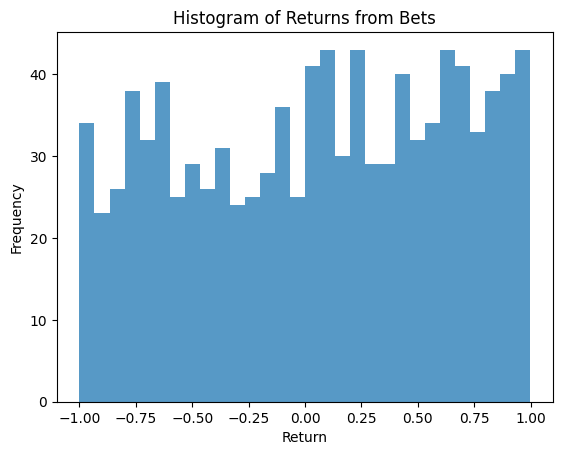

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_bet_sizes(num_bets, true_prob):
    np.random.seed(42)
    outcomes = np.random.rand(num_bets) < true_prob
    bet_sizes = np.random.rand(num_bets)
    returns = bet_sizes * outcomes - bet_sizes * (1 - outcomes)
    return returns

# Paramètres de la simulation
num_bets = 1000
true_prob = 0.55  # Probabilité que le pari soit favorable

# Exécuter la simulation
returns = simulate_bet_sizes(num_bets, true_prob)

# Calculer le rendement total et afficher les résultats
total_return = np.sum(returns)
print(f"Total Return: {total_return}")

# Afficher l'histogramme des retours
plt.hist(returns, bins=30, alpha=0.75)
plt.title('Histogram of Returns from Bets')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()


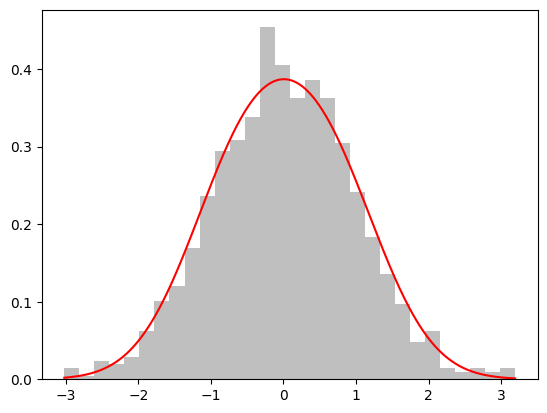

In [44]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Exemple de données
data = np.random.randn(1000)

# Ajustement du mélange de deux Gaussiennes
gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Estimation des responsabilités
responsibilities = gmm.predict_proba(data.reshape(-1, 1))

# Calcul de la taille du pari
bet_size = responsibilities[:, 1]  # Utiliser la deuxième composante comme exemple

# Tracer les données et la taille des paris
plt.hist(data, bins=30, density=True, alpha=0.5, color='gray')
x = np.linspace(min(data), max(data), 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
plt.plot(x, pdf, '-r')
plt.show()


In [45]:
import numpy as np
from sklearn.model_selection import KFold

class PurgedKFold(KFold):
    def __init__(self, n_splits=5, embargo=0):
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.embargo = embargo

    def split(self, X, y=None, groups=None):
        indices = np.arange(len(X))
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(indices, self.n_splits)]
        for start, end in test_starts:
            t_ind = np.arange(start, end)
            train_indices = np.concatenate([np.arange(0, start), np.arange(end, len(X))])
            # Embargo applied here
            if self.embargo > 0:
                train_indices = np.setdiff1d(train_indices, np.arange(end, end + self.embargo))
            yield train_indices, t_ind




In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Création d'un ensemble de données fictif
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Instancier le modèle
model = RandomForestClassifier(random_state=42)

# Instancier le PurgedKFold
n_splits = 5
embargo = 10  # Définir selon la taille de votre ensemble de données
cv = PurgedKFold(n_splits=n_splits, embargo=embargo)

# Effectuer la validation croisée
scores = []
for train_indices, test_indices in cv.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

print("Scores de validation croisée :", scores)


Scores de validation croisée : [0.925, 0.915, 0.875, 0.88, 0.855]
